In [1]:
!pip install git+https://github.com/deepmind/dm-haiku optax jax_tqdm jax pandas git+https://github.com/instadeepai/jumanji.git

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-em2gi918
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-em2gi918
  Resolved https://github.com/deepmind/dm-haiku to commit a32b885949300989b9822eb26142216b37a27f51
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/instadeepai/jumanji.git to /tmp/pip-req-build-53a62bi5
  Running command git clone --filter=blob:none --quiet https://github.com/instadeepai/jumanji.git /tmp/pip-req-build-53a62bi5
  Resolved https://github.com/instadeepai/jumanji.git to commit 185b9fadfafebfee17a3f861b6eed500dfdf52e6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import jax
import jax.numpy as jnp
import pandas as pd
import optax
import haiku as hk
import numpy as np
from network import CustomNetwork

from jax import jit, lax, random, vmap

from jax_tqdm import loop_tqdm

import matplotlib.pyplot as plt

from cartpole import CartPole
from dqn import DQN
from replay_buffer import ReplayBuffer

import jumanji
from jumanji.wrappers import AutoResetWrapper
from jumanji.types import StepType
BATCH_SIZE = 32

In [3]:
from typing import Callable

from base_agent import BaseAgent
from base_env import BaseEnv
from base_buffer import BaseReplayBuffer

def rollout(
    timesteps: int,
    random_seed: int,
    target_net_update_freq: int,
    model: hk.Transformed,
    optimizer: optax.GradientTransformation,
    buffer_state: dict,
    agent: BaseAgent,
    env: BaseEnv,
    replay_buffer: BaseReplayBuffer,
    state_shape: int,
    buffer_size: int,
    epsilon_decay_fn: Callable,
    epsilon_start: float,
    epsilon_end: float,
    decay_rate: float,
) -> dict:
    @loop_tqdm(timesteps)
    @jit
    def _fori_body(i: int, val: tuple):
        (
            model_params,
            target_net_params,
            optimizer_state,
            buffer_state,
            action_key,
            buffer_key,
            env_state,
            all_actions,
            all_obs,
            all_masks,
            all_rewards,
            all_done,
            losses,
        ) = val

        state = env_state
        epsilon = epsilon_decay_fn(epsilon_start, epsilon_end, i, decay_rate)
        action, action_key = agent.act(action_key, model_params, state, epsilon)

        new_state, timestep = env.step(env_state, action)
        env_state = new_state
        reward = timestep.reward
        done = jnp.asarray(timestep.step_type == StepType.LAST)

        experience = (
            jnp.asarray(state.board).reshape(-1),
            jnp.asarray(state.action_mask),
            jnp.asarray(action),
            jnp.asarray(reward),
            jnp.asarray(new_state.board).reshape(-1),
            jnp.asarray(new_state.action_mask),
            jnp.asarray(done),
        )

        buffer_state = replay_buffer.add(buffer_state, experience, i)
        current_buffer_size = jnp.min(jnp.array([i, buffer_size]))

        experiences_batch, buffer_key = replay_buffer.sample(
            buffer_key,
            buffer_state,
            current_buffer_size,
        )

        model_params, optimizer_state, loss = agent.update(
            model_params,
            target_net_params,
            optimizer,
            optimizer_state,
            experiences_batch,
        )

        # update the target parameters every ``target_net_update_freq`` steps
        target_net_params = lax.cond(
            i % target_net_update_freq == 0,
            lambda _: model_params,
            lambda _: target_net_params,
            operand=None,
        )

        all_actions = all_actions.at[i].set(action)
        all_obs = all_obs.at[i].set(jnp.resize(new_state.board, (16,)))
        all_masks = all_masks.at[i].set(new_state.action_mask)
        all_rewards = all_rewards.at[i].set(reward)
        all_done = all_done.at[i].set(done)
        losses = losses.at[i].set(loss)

        val = (
            model_params,
            target_net_params,
            optimizer_state,
            buffer_state,
            action_key,
            buffer_key,
            env_state,
            all_actions,
            all_obs,
            all_masks,
            all_rewards,
            all_done,
            losses,
        )

        return val

    init_key, action_key, buffer_key = vmap(random.PRNGKey)(jnp.arange(3) + random_seed)
    env_state, _ = env.reset(init_key)
    all_actions = jnp.zeros([timesteps])
    all_obs = jnp.zeros([timesteps, *state_shape])
    all_masks = jnp.zeros([timesteps, 4])
    all_rewards = jnp.zeros([timesteps], dtype=jnp.float32)
    all_done = jnp.zeros([timesteps], dtype=jnp.bool_)
    losses = jnp.zeros([timesteps], dtype=jnp.float32)

    model_params = model.init(init_key, jnp.zeros(state_shape))
    target_net_params = model.init(action_key, jnp.zeros(state_shape))
    optimizer_state = optimizer.init(model_params)

    val_init = (
        model_params,
        target_net_params,
        optimizer_state,
        buffer_state,
        action_key,
        buffer_key,
        env_state,
        all_actions,
        all_obs,
        all_masks,
        all_rewards,
        all_done,
        losses,
    )

    vals = lax.fori_loop(0, timesteps, _fori_body, val_init)
    output_dict = {}
    keys = [
        "model_params",
        "target_net_params",
        "optimizer_state",
        "buffer_state",
        "action_key",
        "buffer_key",
        "env_state",
        "all_actions",
        "all_obs",
        "all_masks",
        "all_rewards",
        "all_done",
        "losses",
    ]
    for idx, value in enumerate(vals):
        output_dict[keys[idx]] = value

    return output_dict


In [4]:
# Env parameters
RANDOM_SEED = 1
N_ACTIONS = 4
STATE_SHAPE = (16,)

# Hyperparameters
DISCOUNT = 0.9
NEURONS_PER_LAYER = [128, 256, 512, 512, 256, 128, N_ACTIONS]
TIMESTEPS = 100_000
TARGET_NET_UPDATE_FREQ = 10
BUFFER_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPSILON_START = 0.5
EPSILON_END = 0
DECAY_RATE = 1e-4

In [5]:
buffer_state = {
    "states": jnp.empty((BUFFER_SIZE, *STATE_SHAPE), dtype=jnp.float32),
    "action_masks": jnp.empty((BUFFER_SIZE, 4), dtype=jnp.bool_),
    "actions": jnp.empty((BUFFER_SIZE,), dtype=jnp.int32),
    "rewards": jnp.empty((BUFFER_SIZE,), dtype=jnp.int32),
    "next_states": jnp.empty((BUFFER_SIZE, *STATE_SHAPE), dtype=jnp.float32),
    "new_action_masks": jnp.empty((BUFFER_SIZE, 4), dtype=jnp.bool_),
    "dones": jnp.empty((BUFFER_SIZE,), dtype=jnp.bool_),
}
print(jax.tree_util.tree_map(lambda x: x.shape, buffer_state))

{'action_masks': (128, 4), 'actions': (128,), 'dones': (128,), 'new_action_masks': (128, 4), 'next_states': (128, 16), 'rewards': (128,), 'states': (128, 16)}


In [6]:
model = hk.transform(lambda x: CustomNetwork(output_dim=N_ACTIONS)(x))

def inverse_scaling_decay(epsilon_start, epsilon_end, current_step, decay_rate):
    return epsilon_end + (epsilon_start - epsilon_end) / (1 + decay_rate * current_step)

online_key, target_key = vmap(random.PRNGKey)(jnp.arange(2) + RANDOM_SEED)

env = jumanji.make("Game2048-v1")
env = AutoResetWrapper(env)

replay_buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
online_net_params = model.init(online_key, random.normal(online_key, STATE_SHAPE))
target_net_params = model.init(target_key, random.normal(target_key, STATE_SHAPE))
optimizer = optax.adam(learning_rate=LEARNING_RATE)
optimizer_state = optimizer.init(online_net_params)
agent = DQN(model, DISCOUNT, N_ACTIONS)

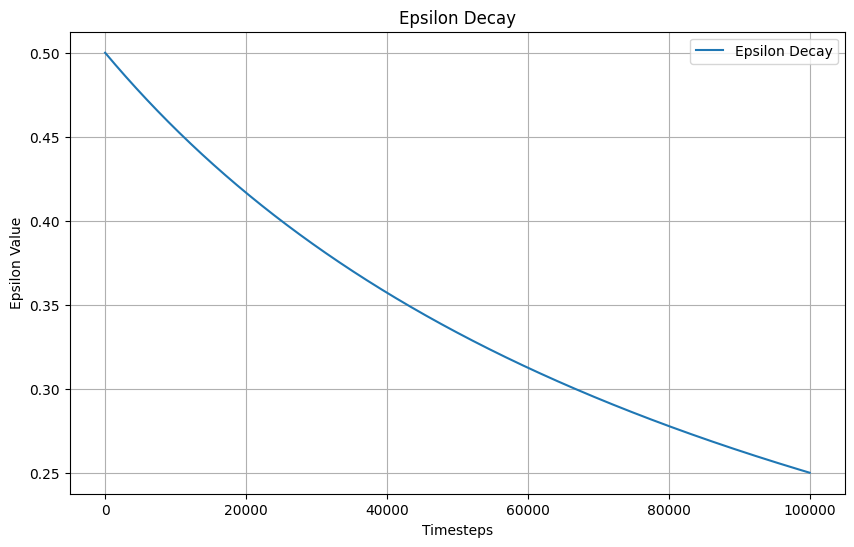

In [7]:
x_values = range(TIMESTEPS)
y_values = [inverse_scaling_decay(EPSILON_START, EPSILON_END, i, DECAY_RATE) for i in x_values]

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label="Epsilon Decay")
plt.title("Epsilon Decay")
plt.xlabel("Timesteps")
plt.ylabel("Epsilon Value")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
jax.tree_util.tree_map(lambda x: x.shape, online_net_params)

{'custom_network/~/conv2_d': {'b': (32,), 'w': (2, 2, 1, 32)},
 'custom_network/~/conv2_d_1': {'b': (64,), 'w': (2, 2, 32, 64)},
 'custom_network/~/linear': {'b': (128,), 'w': (1024, 128)},
 'custom_network/~/linear_1': {'b': (256,), 'w': (128, 256)},
 'custom_network/~/linear_2': {'b': (128,), 'w': (256, 128)},
 'custom_network/~/linear_3': {'b': (64,), 'w': (128, 64)},
 'custom_network/~/linear_4': {'b': (4,), 'w': (64, 4)}}

In [9]:
jax.tree_util.tree_map(lambda x: x.shape, optimizer_state)

(ScaleByAdamState(count=(), mu={'custom_network/~/conv2_d': {'b': (32,), 'w': (2, 2, 1, 32)}, 'custom_network/~/conv2_d_1': {'b': (64,), 'w': (2, 2, 32, 64)}, 'custom_network/~/linear': {'b': (128,), 'w': (1024, 128)}, 'custom_network/~/linear_1': {'b': (256,), 'w': (128, 256)}, 'custom_network/~/linear_2': {'b': (128,), 'w': (256, 128)}, 'custom_network/~/linear_3': {'b': (64,), 'w': (128, 64)}, 'custom_network/~/linear_4': {'b': (4,), 'w': (64, 4)}}, nu={'custom_network/~/conv2_d': {'b': (32,), 'w': (2, 2, 1, 32)}, 'custom_network/~/conv2_d_1': {'b': (64,), 'w': (2, 2, 32, 64)}, 'custom_network/~/linear': {'b': (128,), 'w': (1024, 128)}, 'custom_network/~/linear_1': {'b': (256,), 'w': (128, 256)}, 'custom_network/~/linear_2': {'b': (128,), 'w': (256, 128)}, 'custom_network/~/linear_3': {'b': (64,), 'w': (128, 64)}, 'custom_network/~/linear_4': {'b': (4,), 'w': (64, 4)}}),
 EmptyState())

In [15]:
init_key, action_key, buffer_key = vmap(random.PRNGKey)(jnp.arange(3) + RANDOM_SEED)
env_state, _ = env.reset(init_key)

for i in range(BUFFER_SIZE):

    action, action_key = agent.act(action_key, online_net_params, env_state, 1)
    new_state, timestep = env.step(env_state, action)
    reward = timestep.reward
    done = jnp.asarray(timestep.step_type == StepType.LAST)

    experience = (
        jnp.asarray(env_state.board).reshape(-1),
        jnp.asarray(env_state.action_mask),
        jnp.asarray(action),
        jnp.asarray(reward),
        jnp.asarray(new_state.board).reshape(-1),
        jnp.asarray(new_state.action_mask),
        jnp.asarray(done),
    )

    buffer_state = replay_buffer.add(buffer_state, experience, i)
    env_state = new_state

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [16]:
rollout_params = {
    "timesteps": TIMESTEPS,
    "random_seed": RANDOM_SEED,
    "target_net_update_freq": TARGET_NET_UPDATE_FREQ,
    "model": model,
    "optimizer": optimizer,
    "buffer_state": buffer_state,
    "agent": agent,
    "env": env,
    "replay_buffer": replay_buffer,
    "state_shape": STATE_SHAPE,
    "buffer_size": BUFFER_SIZE,
    "epsilon_decay_fn": inverse_scaling_decay,
    "epsilon_start": EPSILON_START,
    "epsilon_end": EPSILON_END,
    "decay_rate": DECAY_RATE,
}

out = rollout(**rollout_params)

Running for 100,000 iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

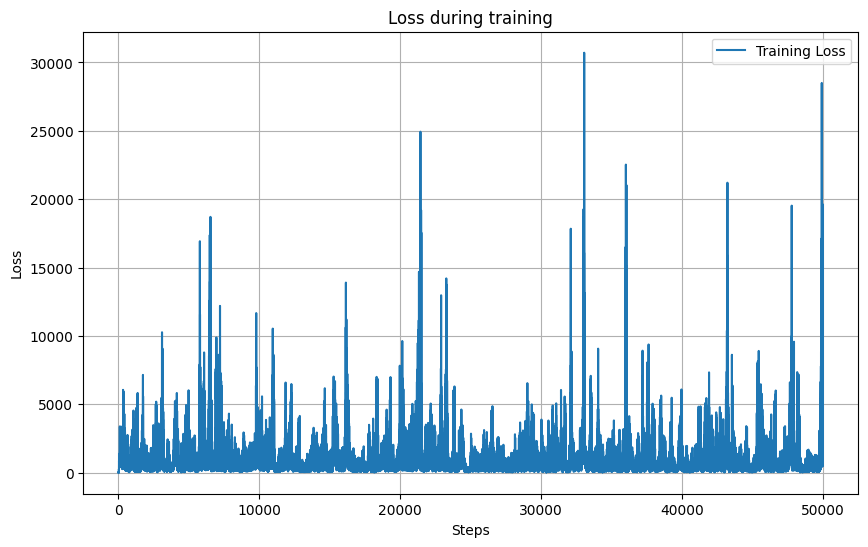

In [26]:
losses = out["losses"][:-TIMESTEPS//2]

plt.figure(figsize=(10, 6))
plt.plot(losses, label="Training Loss")
plt.title("Loss during training")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

       episode  reward
99995      526     0.0
99996      526     0.0
99997      526     0.0
99998      526     0.0
99999      526     0.0


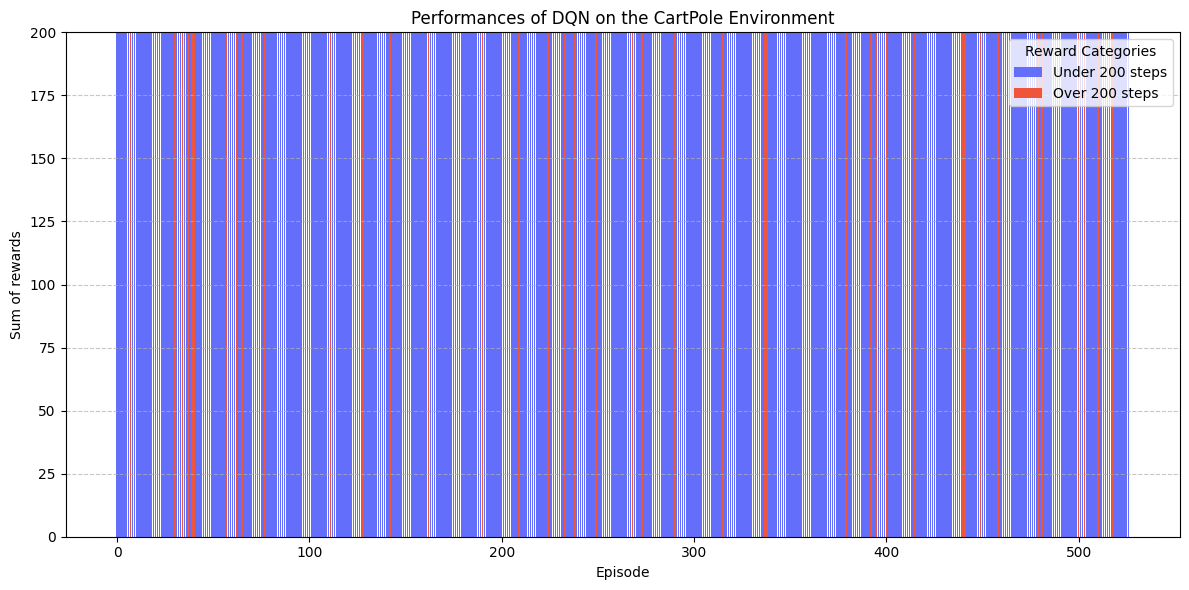

In [20]:
# Assuming `out` and colors are defined as in the provided code
colors = ['#636EFA', '#EF553B']  # Example for Plotly qualitative colors
reward_treshold = 2048
# Create the DataFrame
df = pd.DataFrame(
    data={
        "episode": out["all_done"].cumsum(),
        "reward": out["all_rewards"],
    },
)
print(df.tail())
df["episode"] = df["episode"].shift().fillna(0)

# Aggregate data by episode
episodes_df = df.groupby("episode").agg("sum")

# Define hover text and colors
episodes_df["hover_text"] = np.where(
    episodes_df["reward"] > reward_treshold,
    "Over 200 steps: " + episodes_df["reward"].astype(str),
    "Under 200 steps: " + episodes_df["reward"].astype(str)
)
episodes_df["color"] = np.where(episodes_df["reward"] > reward_treshold, colors[1], colors[0])

# Separate data for different categories
under_200 = episodes_df[episodes_df["reward"] < reward_treshold]
over_200 = episodes_df[episodes_df["reward"] >= reward_treshold]

# Create the figure
plt.figure(figsize=(12, 6))

# Plot bars for "under 200 steps"
plt.bar(under_200.index, under_200["reward"], color=colors[0], label="Under 200 steps")

# Plot bars for "over 200 steps"
plt.bar(over_200.index, over_200["reward"], color=colors[1], label="Over 200 steps")

# Add labels, title, and legend
plt.title("Performances of DQN on the CartPole Environment")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.ylim(0, 200)
plt.legend(title="Reward Categories")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [21]:
df.groupby("episode").agg("sum").max()

,0
reward,3356.0
